# Exploring Deceptive Mazes with Novelty Search

_This tutorial is part of the series of pyribs tutorials! See [here](https://docs.pyribs.org/en/latest/tutorials.html) for the list of all tutorials and the order in which they should be read._

Consider a robot that needs to solve the maze below. To solve this problem, we need to train a robot _policy_ that enables the robot to move from the starting position (red dot) to the goal position (green star).

![Maze](_static/maze.svg)

At first glance, a reasonable approach seems to be to _optimize an objective_, i.e., to minimize the Euclidean distance between the robot's current position and the goal position. However, this maze is _deceptive_, in that minimizing the Euclidean distance will cause the robot to get stuck behind a wall that is close to the goal, as shown below.

![The maze with a robot stuck due to following Euclidean distance.](_static/maze-stuck.svg)

In fact, in order to solve the maze, the robot actually has to defy the objective! Namely, it has to _increase_ its Euclidean distance from the goal position by going around the walls, as shown below.

![The maze with a robot properly solving it.](_static/maze-solved.svg)

This insight forms the basis for Novelty Search (NS), introduced in [Lehman 2011](https://web.archive.org/web/20220707041732/https://eplex.cs.ucf.edu/papers/lehman_ecj11.pdf). In short, NS ignores the objective completely and instead seeks to discover a diverse set of solutions. For example, in the maze below, NS could search for individual robot policies that reach every possible $(x, y)$ position in the maze:

![The maze with many robot policies scattered throughout it.](_static/maze-all.svg)

Ultimately, the result is two-fold: First, without considering the objective, NS solves the maze! Second, by seeking diversity, a single run of NS has created policies that go to every position in the maze, rather than just one position. In this tutorial, we will show how to achieve these results by providing an overview of NS and implementing it in pyribs.

## Setup

In [ ]:
# `jax<0.6.0` since Kheperax depends on a jax function that is deprecated in 0.6.0.
%pip install ribs[visualize] kheperax "jax[cuda12]<0.6.0" tqdm

In [2]:
import sys

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from jax.flatten_util import ravel_pytree
from kheperax.tasks.config import KheperaxConfig
from kheperax.tasks.main import KheperaxTask
from tqdm import tqdm, trange

## Maze Environment with Kheperax

We begin by setting up the maze environment in [Kheperax](https://github.com/adaptive-intelligent-robotics/Kheperax/tree/main). Kheperax is a

TODO: Elaborate on the robot in the maze.

<img alt="Kheperax robot with sensors" width="40%" src="https://raw.githubusercontent.com/adaptive-intelligent-robotics/Kheperax/main/img/gif/target_policy_standard.gif" />

Kheperax is...

Accelerated in JAX...

For more info on Kheperax...

First, we set up JAX's random keys.

In [3]:
seed = 42
random_key = jax.random.PRNGKey(seed)
random_key, subkey = jax.random.split(random_key)

Next, we set up the Kheperax task.

In [4]:
# Define Task configuration
config_kheperax = KheperaxConfig.get_default()
config_kheperax.mlp_policy_hidden_layer_sizes = (8, 8)

# Create Kheperax Task.
(
    env,
    policy_network,
    scoring_fn,
) = KheperaxTask.create_default_task(
    config_kheperax,
    random_key=subkey,
)

scoring_fn = jax.jit(scoring_fn)

The networks in Kheperax are represented as pytrees, while pyribs typically expects 1D parameters. To be compatible with pyribs, we flatten the pytrees into vectors. Here, we pass a single batch of observations through the network in order to set up the `_array_to_pytree_fn` for un-flattening solution parameters, and also to retrieve the `solution_dim`.

TODO: edit

In [5]:
fake_batch = jnp.zeros(shape=(1, env.observation_size))
random_key, subkey = jax.random.split(random_key)
example_init_parameters = policy_network.init(subkey, fake_batch)
flattened_parameters, _array_to_pytree_fn = ravel_pytree(example_init_parameters)
solution_dim = len(flattened_parameters)
print("solution_dim:", solution_dim)

solution_dim: 138


We can also retrieve the bounds of the measure space (measures are referred to as behavior
descriptors in Kheperax).

In [6]:
min_bd, max_bd = env.behavior_descriptor_limits
bounds = [(min_bd[0], max_bd[0]), (min_bd[1], max_bd[1])]
print("bounds:", bounds)

bounds: [(0.0, 1.0), (0.0, 1.0)]


Finally, we define an evaluation function that... TODO

In [7]:
def evaluate(params, random_key):
    params = jnp.asarray(params)
    params_pytree = jax.vmap(_array_to_pytree_fn)(params)

    random_key, subkey = jax.random.split(random_key)
    objectives, measures, info, _ = scoring_fn(params_pytree, subkey)

    best_obj = 0.0
    worst_obj = -0.5
    objectives = (objectives - worst_obj) / (best_obj - worst_obj) * 100

    return np.asarray(objectives), np.asarray(measures), info

## Novelty Search in pyribs

TODO: talk about how novelty search is a precursor to QD and does not consider objective
TODO: mention NS equation

### ProximityArchive

TODO

Note proximityarchive does not take in bounds

In [8]:
from ribs.archives import GridArchive, ProximityArchive

archive = ProximityArchive(solution_dim=solution_dim,
                           measure_dim=2,
                           k_neighbors=15,
                           novelty_threshold=0.01)
                           # k_neighbors=100,
                           # novelty_threshold=0.042)

result_archive = GridArchive(solution_dim=solution_dim,
                             dims=(100, 100),
                             ranges=bounds)

### Emitters

TODO

In [9]:
from ribs.emitters import EvolutionStrategyEmitter

emitters = [
    EvolutionStrategyEmitter(
        archive,
        # Created earlier when we initialized the `_array_to_pytree_fn`.
        x0=np.asarray(flattened_parameters),
        sigma0=0.5,
        ranker="nov",
        selection_rule="mu",
        restart_rule="basic",
        batch_size=30
    ) for _ in range(5)
]

### Scheduler

In [10]:
from ribs.schedulers import Scheduler

scheduler = Scheduler(archive, emitters, result_archive=result_archive)

## Running Novelty Search

TODO: Talk about objective -- we need it for GridArchive?

In [11]:
total_itrs = 2500

for itr in trange(1, total_itrs + 1, file=sys.stdout, desc='Iterations'):
    solutions = scheduler.ask()

    random_key, subkey = jax.random.split(random_key)
    objectives, measures, info = evaluate(solutions, subkey)
    
    scheduler.tell(objectives, measures)

    # Logging.
    if itr % 50 == 0 or itr == total_itrs:
        tqdm.write(f"Iteration {itr:5d} | "
                   f"Archive Size: {archive.stats.num_elites} "
                   f"Coverage: {result_archive.stats.coverage * 100:6.3f}%")

Iteration    50 | Archive Size: 2402 Coverage: 10.340%                             
Iteration   100 | Archive Size: 3217 Coverage: 13.770%                             
Iteration   150 | Archive Size: 3881 Coverage: 16.620%                             
Iteration   200 | Archive Size: 4476 Coverage: 18.830%                             
Iteration   250 | Archive Size: 5001 Coverage: 20.870%                             
Iteration   300 | Archive Size: 5345 Coverage: 22.250%                             
Iteration   350 | Archive Size: 5628 Coverage: 23.190%                             
Iteration   400 | Archive Size: 5925 Coverage: 24.080%                             
Iteration   450 | Archive Size: 6231 Coverage: 25.130%                             
Iteration   500 | Archive Size: 6475 Coverage: 25.960%                             
Iteration   550 | Archive Size: 6652 Coverage: 26.630%                             
Iteration   600 | Archive Size: 6814 Coverage: 27.240%                      

## Visualization

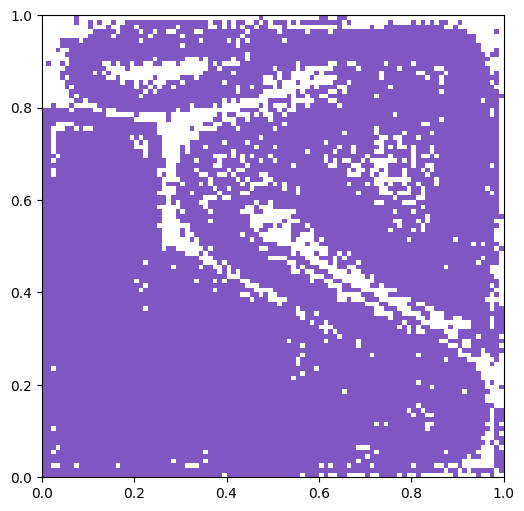

In [25]:
from ribs.visualize import grid_archive_heatmap

# TODO: Show objective version too.
plt.figure(figsize=(8, 6))
grid_archive_heatmap(
    result_archive,
    cmap=["#7e57c2"],
    vmin=0,
    vmax=100,
    cbar=None,
    aspect="equal",
)

## Citation

If you find this tutorial useful, please cite it as:

```text
@article{pyribs_ns_maze,
  title   = {Exploring Deceptive Mazes with Novelty Search},
  author  = {Bryon Tjanaka},
  journal = {pyribs.org},
  year    = {2025},
  url     = {https://docs.pyribs.org/en/stable/tutorials/ns_maze.html}
}
```